In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from lfw_dataset import fetch_lfw_dataset

data, attrs = fetch_lfw_dataset()

In [2]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 6075)
(3143, 6075)


In [3]:
X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

In [4]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

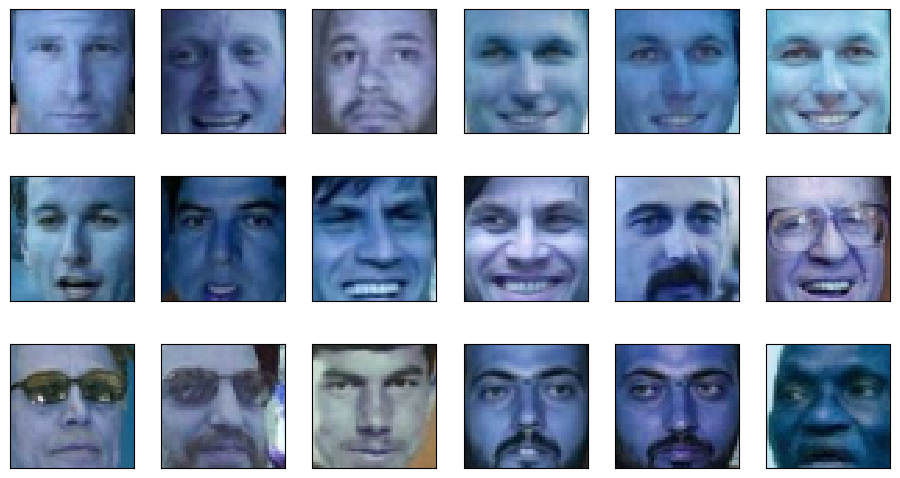

In [5]:
plot_gallery(X_train, image_h, image_w)

In [6]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, rate):
        super(DisplayCallback, self).__init__()
        self.model = model
        self.rate = rate

    def on_epoch_end(self, epoch, logs=None):
        model = self.model
        if epoch % self.rate == 0:
            idx = np.random.choice(X_train.shape[0])
            plt.subplot(221)
            plt.imshow(X_train[idx].reshape(
                (image_h, image_w, 3)
            ))
            plt.subplot(222)
            plt.imshow(tf.reshape(
                model(X_train[tf.newaxis, idx]), (image_h, image_w, 3)
            ))
            idx = np.random.choice(X_val.shape[0])
            plt.subplot(223)
            plt.imshow(X_val[idx].reshape(
                (image_h, image_w, 3)
            ))
            plt.subplot(224)
            plt.imshow(tf.reshape(
                model(X_val[tf.newaxis, idx]), (image_h, image_w, 3)
            ))
            plt.show()

In [7]:
class Sampling(tf.keras.layers.Layer):
    '''sampling z'''

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(z_log_var) * epsilon

encoder_inp = tf.keras.layers.Input(shape=(image_h * image_w * 3,))
encoding = tf.keras.layers.Dense(100)(encoder_inp)#encoder_input
mean = tf.keras.layers.Dense(100)(encoding)#mean
log_var = tf.keras.layers.Dense(100)(encoding)#variance
sample = Sampling()([mean, log_var])

encoder = tf.keras.Model(encoder_inp, [mean, log_var, sample])


dec_inp = tf.keras.layers.Input(shape=(100,))#decoder_input
decoding = tf.keras.layers.Dense(units=image_h * image_w * 3,activation='sigmoid')(dec_inp)#decoding

decoder = tf.keras.Model(dec_inp, decoding)

In [20]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = None
        self.reconstruction_loss_tracker = None
        self.kl_loss = None

    @tf.function
    def KL_divergence(self, mu, logsigma):
        kl_div = -0.5 * tf.reduce_sum(1 + logsigma - tf.square(mu) - tf.exp(logsigma), axis=1)
        return tf.reduce_mean(kl_div)

    @tf.function
    def log_likelihood(self, x, z):
        reconstruction = self.decoder(z)
        return tf.reduce_mean(tf.reduce_sum(tf.square(x-reconstruction), axis=-1))

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_sigma, z = self.encoder(data)
            x_decoded_mean = self.decoder(z)
            log_likelihood = self.log_likelihood(data, z)
            kl_loss = self.KL_divergence(z_mean, z_log_sigma)
            total_loss = log_likelihood + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss = total_loss
        self.reconstruction_loss = log_likelihood
        self.kl_loss = kl_loss
        return {
            "loss": self.total_loss,
            "reconstruction_loss": self.reconstruction_loss,
            "kl_loss": self.kl_loss,
        }

    def call(self, inputs):
        reconstruction = self.decoder(inputs)
        return reconstruction

In [26]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
callback = DisplayCallback(vae, 2)

Epoch 1/30
1248/1250 [============================>.] - ETA: 0s - loss: 63.4418 - reconstruction_loss: 45.3089 - kl_loss: 18.1330

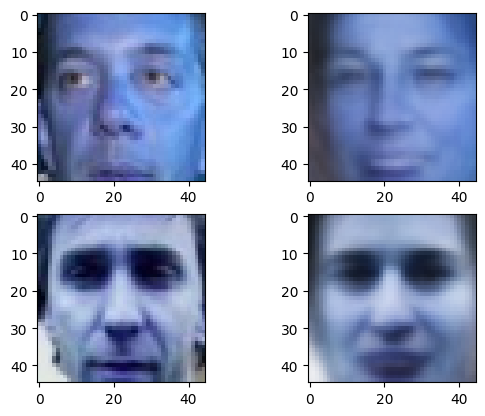

1250/1250 [==============================] - 23s 18ms/step - loss: 63.4314 - reconstruction_loss: 45.3018 - kl_loss: 18.1296 - val_loss: 63.1570 - val_reconstruction_loss: 44.7349 - val_kl_loss: 18.4221
Epoch 2/30
1250/1250 [==============================] - 21s 17ms/step - loss: 63.2866 - reconstruction_loss: 45.1695 - kl_loss: 18.1170 - val_loss: 63.4244 - val_reconstruction_loss: 46.1358 - val_kl_loss: 17.2886
Epoch 3/30
1249/1250 [============================>.] - ETA: 0s - loss: 62.9985 - reconstruction_loss: 44.9089 - kl_loss: 18.0895

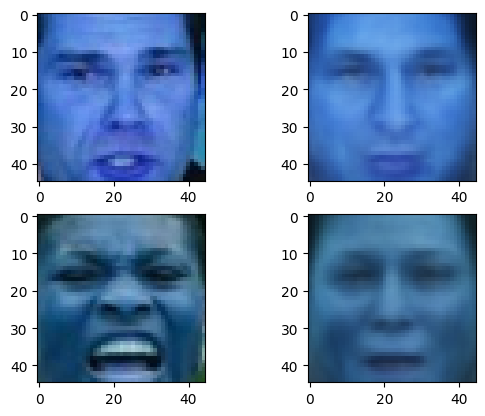

1250/1250 [==============================] - 23s 18ms/step - loss: 62.9938 - reconstruction_loss: 44.9054 - kl_loss: 18.0883 - val_loss: 62.5554 - val_reconstruction_loss: 44.2032 - val_kl_loss: 18.3523
Epoch 4/30
1250/1250 [==============================] - 22s 18ms/step - loss: 63.1212 - reconstruction_loss: 45.0582 - kl_loss: 18.0631 - val_loss: 63.1469 - val_reconstruction_loss: 45.0234 - val_kl_loss: 18.1235
Epoch 5/30
1250/1250 [==============================] - ETA: 0s - loss: 62.7816 - reconstruction_loss: 44.8158 - kl_loss: 17.9658

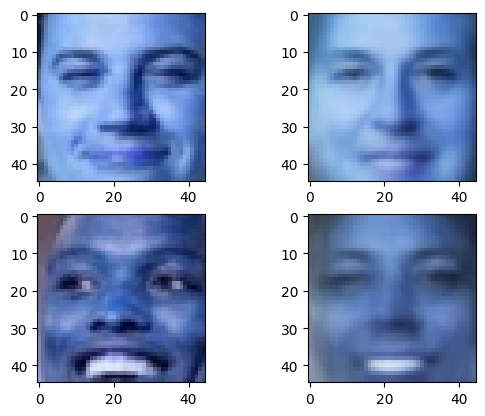

1250/1250 [==============================] - 51s 41ms/step - loss: 62.7816 - reconstruction_loss: 44.8158 - kl_loss: 17.9658 - val_loss: 63.1332 - val_reconstruction_loss: 44.5541 - val_kl_loss: 18.5791
Epoch 6/30
1250/1250 [==============================] - 20s 16ms/step - loss: 62.7845 - reconstruction_loss: 44.8599 - kl_loss: 17.9246 - val_loss: 60.9904 - val_reconstruction_loss: 44.5174 - val_kl_loss: 16.4730
Epoch 7/30
1249/1250 [============================>.] - ETA: 0s - loss: 62.3076 - reconstruction_loss: 44.4424 - kl_loss: 17.8652

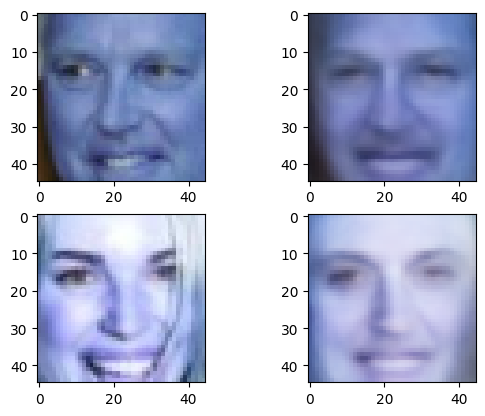

1250/1250 [==============================] - 22s 18ms/step - loss: 62.2966 - reconstruction_loss: 44.4328 - kl_loss: 17.8639 - val_loss: 61.0465 - val_reconstruction_loss: 43.7218 - val_kl_loss: 17.3247
Epoch 8/30
1250/1250 [==============================] - 21s 17ms/step - loss: 62.3656 - reconstruction_loss: 44.4625 - kl_loss: 17.9031 - val_loss: 61.3515 - val_reconstruction_loss: 44.6040 - val_kl_loss: 16.7475
Epoch 9/30
1248/1250 [============================>.] - ETA: 0s - loss: 62.3168 - reconstruction_loss: 44.4856 - kl_loss: 17.8312

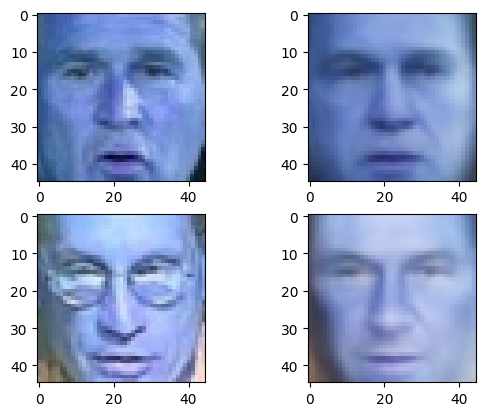

1250/1250 [==============================] - 22s 18ms/step - loss: 62.3307 - reconstruction_loss: 44.4981 - kl_loss: 17.8327 - val_loss: 62.0903 - val_reconstruction_loss: 44.8116 - val_kl_loss: 17.2787
Epoch 10/30
1250/1250 [==============================] - 22s 17ms/step - loss: 62.4950 - reconstruction_loss: 44.6162 - kl_loss: 17.8789 - val_loss: 61.1665 - val_reconstruction_loss: 42.7052 - val_kl_loss: 18.4613
Epoch 11/30
1247/1250 [============================>.] - ETA: 0s - loss: 62.1862 - reconstruction_loss: 44.3476 - kl_loss: 17.8387

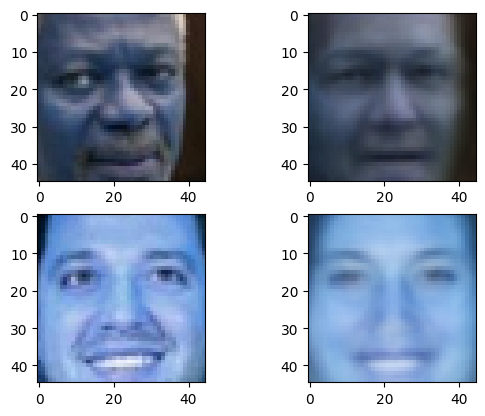

1250/1250 [==============================] - 21s 17ms/step - loss: 62.1945 - reconstruction_loss: 44.3549 - kl_loss: 17.8397 - val_loss: 61.4698 - val_reconstruction_loss: 42.5458 - val_kl_loss: 18.9240


In [27]:
history = vae.fit(
    X_train,
    epochs=30,
    batch_size = 4,
    validation_data = (X_val, X_val),
    callbacks=[callback]
                  )

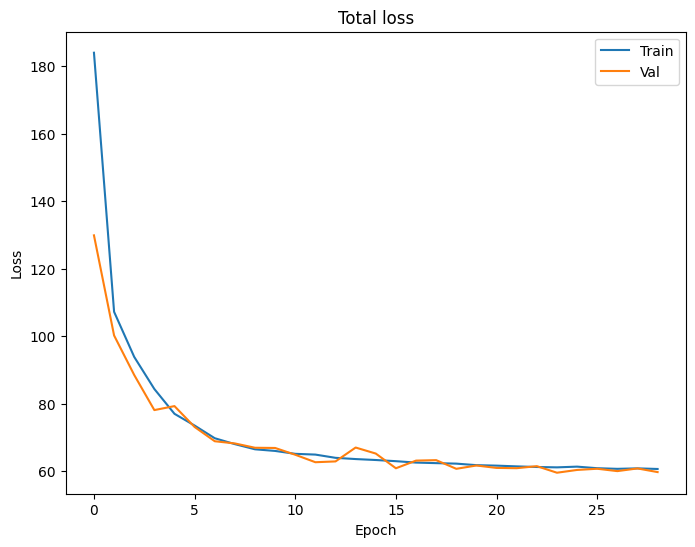

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Total loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])

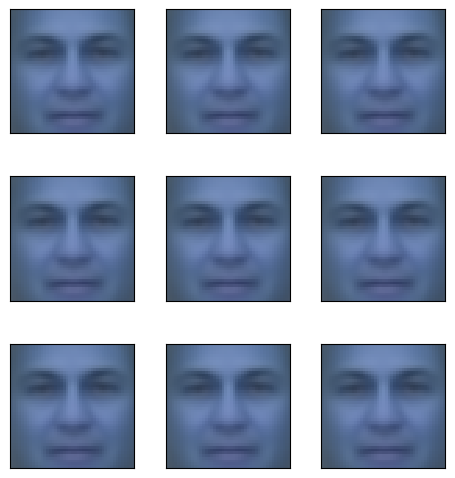

In [19]:
z = np.random.randn(9, 100)*0.01
output = decoder(z).numpy()
plot_gallery(output, image_h, image_w, n_row=3, n_col=3)